In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from scipy.stats import poisson, ttest_ind

In [7]:
%reset -f

In [2]:
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.9 MB/s eta 0:00:0000:01


### Выгрузка данных и подготовка данных

In [3]:
data  = pd.read_parquet('/kaggle/input/datasets/faibus/diploma/gmv_dataset.parquet', engine='fastparquet')
stock = pd.read_parquet('/kaggle/input/datasets/faibus/diploma/stock_data.parquet', engine='fastparquet')

# работа с уценкой
discounted_goods = pd.read_excel('/kaggle/input/datasets/faibus/diploma/sku_info.xlsx')[['SKU_id', 'is_discounted']] 
discounted_goods_list = set(discounted_goods.query(" is_discounted == 1 ")['SKU_id'])

# убираем уценённые товары из наших датасетов
data = data.query("SKU_id not in @discounted_goods_list")
stock = stock.query("SKU_id not in @discounted_goods_list")

# Находим SKU с очень низким оборотом для дальнейшего удаления
sku_gmv = data.groupby(['SKU_id'], as_index = False).agg({'GMV_wo_VAT': 'sum'})
total_gmv = data['GMV_wo_VAT'].sum()
print(f"""{round((sku_gmv.query(" GMV_wo_VAT < 25000 ")['GMV_wo_VAT'].sum() / total_gmv)*100,1)}% оборота датасет удалено из-за очень низкого оборота SKU""")
low_gmv_sku_to_delete = set(sku_gmv.query(" GMV_wo_VAT < 25000 ")['SKU_id'])

# Удаляем SKU с очень низким оборотом 
data = data.query("SKU_id not in @low_gmv_sku_to_delete")
stock = stock.query("SKU_id not in @low_gmv_sku_to_delete")

1.0% оборота датасет удалено из-за очень низкого оборота SKU


### Иллюстрация проблемы с дубликатами в данных
В наш датасет откуда-то затесались проблемы с дубликатами в данных. Это не ошибка при джойне, это мастер-система хранит данные о двух транзакциях. Как можно увидеть из примера, проблема состоит в SupplierID. Такого не должно существовать, одна SKU существует только для одного поставщика / селлера. Исправим эти неточности, заполнив всё одним единственным брендом, поставщиком, селлером и тд. 

In [4]:
data.query(' SKU_id == 140183682 ').head(10)

,YYYYMM,Date,Category3,Category4,Brand,SupplierID,SellerID,SKU_id,is_promo,stock_qty,GMV_wo_VAT,GMV_wo_VAT_Acc,Items_Acc
61934,202401,2024-01-01,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,92,0.0,9142.500000,3
61935,202401,2024-01-02,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,90,0.0,6205.833300,2
61936,202401,2024-01-03,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,87,0.0,18728.333200,6
61937,202401,2024-01-04,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,80,0.0,3047.500000,1
61938,202401,2024-01-05,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,80,0.0,28832.550067,9
61939,202401,2024-01-06,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,72,0.0,9200.833300,3
61940,202401,2024-01-07,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,70,0.0,18799.166500,6
61941,202401,2024-01-08,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,63,0.0,12642.499900,4
61942,202401,2024-01-09,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,60,0.0,12380.000000,4
61943,202401,2024-01-10,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,56,0.0,3162.500000,1


Eсть проблемы в двух столбцах - SupplierID (для одной SKU видим вплоть до 8 различных поставщиков), SellerID (для одной SKU видим 2 различных селлера). У данной проблемы достаточно простое решение - заполнение всех таких случаев единым ID для селлеров и поставщиков.

Шаги:
1. Находим для каждой SKU_id - SupplierID и SellerID с максимальным оборотом.
2. Заполняем все строки датасета корректными SupplierID и SellerID для каждой SKU. 
3. Формируем итоговый датасет без дубликатов через соответствующие агрегатные функции для каждой из колонок (stock_qty нужно брать как среднее для каждой даты, т.к. джойн накатывался на SKU_id)

In [5]:
data_mistakes = data \
    .groupby(['SKU_id'], as_index = False) \
    .agg({'Category3':'nunique', 'Category4': 'nunique', 'Brand': 'nunique', 'SupplierID': 'nunique', 'SellerID':'nunique'})

data_mistakes.describe()

,SKU_id,Category3,Category4,Brand,SupplierID,SellerID
count,2.221500e+04,22215.0,22215.0,22215.0,22215.000000,22215.000000
mean,1.186378e+09,1.0,1.0,1.0,1.472564,1.379113
std,5.785293e+08,0.0,0.0,0.0,0.594649,0.485177
min,1.401837e+08,1.0,1.0,1.0,1.000000,1.000000
25%,7.556999e+08,1.0,1.0,1.0,1.000000,1.000000
50%,1.250612e+09,1.0,1.0,1.0,1.000000,1.000000
75%,1.624268e+09,1.0,1.0,1.0,2.000000,2.000000
max,2.850435e+09,1.0,1.0,1.0,8.000000,2.000000


In [6]:
# Оставляем для каждой SKU один единственный SupplierID и SellerID
top_supplier_seller = data.groupby(['SKU_id', 'SupplierID', 'SellerID'], as_index=False) \
    .agg({'GMV_wo_VAT': 'sum'}) \
    .sort_values(['SKU_id', 'GMV_wo_VAT'], ascending=[True, False]) \
    .drop_duplicates(subset=['SKU_id'], keep='first')[['SKU_id', 'SupplierID', 'SellerID']]

# Объединяем с исходным датасетом, заменяя некорректные ID
data = data.drop(columns=['SupplierID', 'SellerID'])  # удаляем старые некорректные колонки
data = data.merge(top_supplier_seller, on='SKU_id', how='left')
data = data[['YYYYMM', 'Date', 'Category3', 'Category4', 'Brand', 'SupplierID', 'SellerID', 'SKU_id', 'is_promo', 'stock_qty', 'GMV_wo_VAT', 'GMV_wo_VAT_Acc', 'Items_Acc']]

# Удаляем дубликаты и агрегируем значения
data = data.groupby(['YYYYMM', 'Date', 'Category3', 'Category4', 'Brand', 'SupplierID', 'SellerID', 'SKU_id', 'is_promo'], as_index=False) \
    .agg({'stock_qty': 'mean', 'GMV_wo_VAT': 'sum', 'GMV_wo_VAT_Acc': 'sum', 'Items_Acc': 'sum'}) 

### Создание "полотна"
Мы создаём для каждой пары sku_id и даты отдельную строку в датасете. В качестве результата получаем датасет из двух столбцов 'SKU_id' и 'date'. На данном этапе учитываются абсолютно все такие пары (если SKU появилась в 25-ом году, то на данном этапе для неё будут все даты и в 24-ом году).

In [7]:
# Переименовываем колонку
stock = stock.rename(columns = {'DATE': 'date'})

# Получаем уникальные товары
unique_items = data['SKU_id'].unique()

# Создаем полный диапазон дат
date_range = pd.date_range(start = '2024-01-01', end = '2025-09-30', freq='D')

# Создаем MultiIndex со всеми комбинациями товар-дата
multi_index = pd.MultiIndex.from_product([unique_items, date_range], names = ['SKU_id', 'date'])

# Создаем полный датафрейм-шаблон
complete_template = pd.DataFrame(index=multi_index).reset_index()

### Наполнение "полотна" данными по стокам

На данном этапе мы:
1. Джойним стоки к нашему полотну с предыдущего этапа
2. Убираем даты, в котороые стока не существовало (минимальная дата для каждой SKU = дата первого появления стоков SKU)

In [8]:
# Приводим даты к datetime в обоих датафреймах
complete_template['date'] = pd.to_datetime(complete_template['date'])
stock['date'] = pd.to_datetime(stock['date'])

# Переименовываем колонку
stock = stock.rename(columns={'DATE': 'date'})

# Теперь объединяем
merged_df = pd.merge(
    complete_template,
    stock[['SKU_id', 'date', 'stock_qty']],
    on=['SKU_id', 'date'],
    how='left'
)

# Заполняем пропуски нулями
merged_df['stock_qty'] = merged_df['stock_qty'].fillna(0)

# Находим первую дату с положительным стоком для каждого товара
first_stock_dates = merged_df[merged_df['stock_qty'] > 0].groupby('SKU_id')['date'].min()

# Создаем Series с первой датой для каждого товара
first_dates_series = merged_df['SKU_id'].map(first_stock_dates)

# Фильтруем: оставляем только строки, где дата >= первой даты с стоком
mask = (merged_df['date'] >= first_dates_series) | first_dates_series.isna()

# Применяем фильтр
filtered_df = merged_df[mask].copy()

### Создаём датасет с информацией о перерывах в наличии товара на стоке

In [9]:
def analyze_stock_breaks_fast(filtered_df):
    """
    Быстрый анализ перерывов между днями наличия стока
    """
    # 1. Фильтруем только дни, когда сток был > 0
    stock_days = filtered_df[filtered_df['stock_qty'] > 0].copy()
    
    # 2. Сортируем по товару и дате для корректного вычисления разниц
    stock_days = stock_days.sort_values(['SKU_id', 'date'])
    
    # 3. Вычисляем разницу в днях между последовательными днями с стоком
    # для каждого товара отдельно
    stock_days['days_between_stock'] = stock_days.groupby('SKU_id')['date'].diff().dt.days
    
    # 4. Убираем NaN значения (первые дни для каждого товара)
    breaks_with_nan = stock_days['days_between_stock'].dropna()
    
    # 5. Вычитаем 1 день, потому что нам нужен перерыв между днями,
    # а не разница в датах
    # Пример: даты 01-01 и 01-03 -> разница 2 дня, но перерыв 1 день (02-01)
    breaks_with_gaps = breaks_with_nan - 1
    
    # 6. Фильтруем только положительные перерывы (> 0 дней)
    # Исключаем последовательные дни (перерыв = 0)
    positive_breaks = breaks_with_gaps[breaks_with_gaps > 0]
    
    print(f"Найдено перерывов: {len(positive_breaks)}")
    
    return positive_breaks

breaks_series = analyze_stock_breaks_fast(filtered_df)

Найдено перерывов: 95040


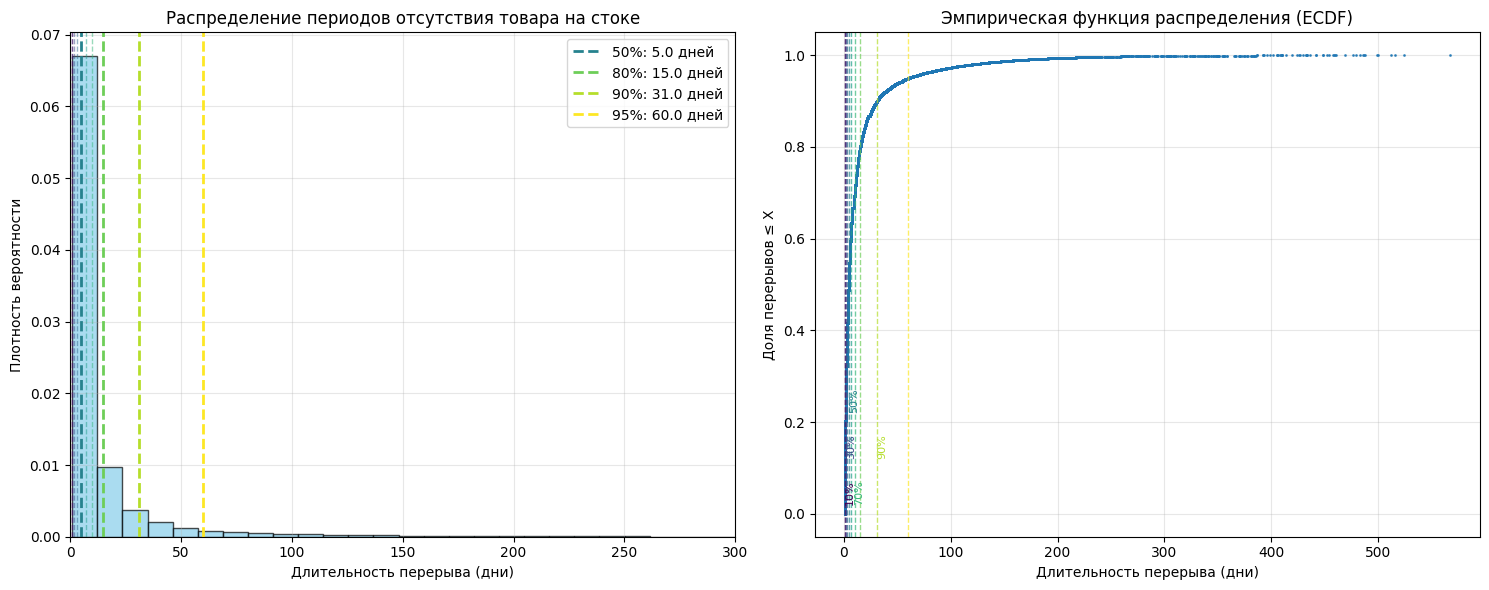

Детальная статистика перерывов:
Общее количество перерывов: 95040
Минимальный перерыв: 1.0 дней
Максимальный перерыв: 567.0 дней
Средний перерыв: 14.3 дней
Медиана перерывов: 5.0 дней

Перцентили:
  10%: 1.0 дней
  20%: 1.0 дней
  30%: 2.0 дней
  40%: 3.0 дней
  50%: 5.0 дней
  60%: 7.0 дней
  70%: 10.0 дней
  80%: 15.0 дней
  90%: 31.0 дней
  95%: 60.0 дней


In [10]:
def plot_breaks_distribution(breaks_series):
    """
    Визуализирует распределение перерывов между периодами стока
    """
    
    # Вычисляем перцентили
    percentiles = {
        '10%': breaks_series.quantile(0.10),
        '20%': breaks_series.quantile(0.20),
        '30%': breaks_series.quantile(0.30),
        '40%': breaks_series.quantile(0.40),
        '50%': breaks_series.quantile(0.50),
        '60%': breaks_series.quantile(0.60),
        '70%': breaks_series.quantile(0.70), 
        '80%': breaks_series.quantile(0.80),
        '90%': breaks_series.quantile(0.90),
        '95%': breaks_series.quantile(0.95)
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Гистограмма с перцентилями
    n, bins, patches = ax1.hist(breaks_series, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    
    # Цвета для перцентилей
    colors = plt.cm.viridis(np.linspace(0, 1, len(percentiles)))
    
    # Отображаем только ключевые перцентили на легенде чтобы не перегружать
    key_percentiles = {'50%': '50%', '80%': '80%', '90%': '90%', '95%': '95%'}
    
    for i, (label, value) in enumerate(percentiles.items()):
        color = colors[i]
        if label in key_percentiles:
            ax1.axvline(value, color=color, linestyle='--', linewidth=2, 
                       label=f'{label}: {value:.1f} дней')
        else:
            ax1.axvline(value, color=color, linestyle='--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel('Длительность перерыва (дни)')
    ax1.set_ylabel('Плотность вероятности')
    ax1.set_title('Распределение периодов отсутствия товара на стоке')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 300)
    
    # 2. Эмпирическая функция распределения (ECDF)
    sorted_breaks = np.sort(breaks_series)
    y = np.arange(1, len(sorted_breaks) + 1) / len(sorted_breaks)
    
    ax2.plot(sorted_breaks, y, marker='.', linestyle='none', alpha=0.8, markersize=2)
    ax2.set_xlabel('Длительность перерыва (дни)')
    ax2.set_ylabel('Доля перерывов ≤ X')
    ax2.set_title('Эмпирическая функция распределения (ECDF)')
    ax2.grid(True, alpha=0.3)
    
    # Добавляем все перцентили на ECDF
    for i, (label, value) in enumerate(percentiles.items()):
        color = colors[i]
        ax2.axvline(value, color=color, linestyle='--', linewidth=1, alpha=0.7)
        if i % 2 == 0:
            ax2.text(value, 0.02 + (i * 0.05) % 0.3, f'{label}', 
                    rotation=90, va='bottom', color=color, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Статистика
    print("Детальная статистика перерывов:")
    print(f"Общее количество перерывов: {len(breaks_series)}")
    print(f"Минимальный перерыв: {breaks_series.min():.1f} дней")
    print(f"Максимальный перерыв: {breaks_series.max():.1f} дней")
    print(f"Средний перерыв: {breaks_series.mean():.1f} дней")
    print(f"Медиана перерывов: {breaks_series.median():.1f} дней")
    print("\nПерцентили:")
    for label, value in percentiles.items():
        print(f"  {label}: {value:.1f} дней")
    
    return percentiles

# Запускаем визуализацию
percentiles = plot_breaks_distribution(breaks_series)

In [11]:
def get_max_breaks_by_sku(filtered_df):
    """
    Возвращает датафрейм с максимальным перерывом для каждого SKU
    
    Parameters:
    -----------
    filtered_df : DataFrame
        Исходный датафрейм с колонками ['SKU_id', 'date', 'stock_qty']
        
    Returns:
    --------
    DataFrame с колонками ['SKU_id', 'max_break']
    """
    # 1. Фильтруем только дни, когда сток был > 0
    stock_days = filtered_df[filtered_df['stock_qty'] > 0].copy()
    
    # 2. Сортируем по товару и дате для корректного вычисления разниц
    stock_days = stock_days.sort_values(['SKU_id', 'date'])
    
    # 3. Вычисляем разницу в днях между последовательными днями с стоком
    # для каждого товара отдельно
    stock_days['days_between_stock'] = stock_days.groupby('SKU_id')['date'].diff().dt.days
    
    # 4. Вычитаем 1 день, чтобы получить перерыв между днями
    stock_days['break_duration'] = stock_days['days_between_stock'] - 1
    
    # 5. Фильтруем только положительные перерывы (> 0 дней)
    positive_breaks = stock_days[stock_days['break_duration'] > 0]
    
    # 6. Группируем по SKU и находим максимальный перерыв
    max_breaks = positive_breaks.groupby('SKU_id')['break_duration'].max().reset_index()
    max_breaks.columns = ['SKU_id', 'max_break']
    
    # 7. Добавляем SKU, у которых нет перерывов (устанавливаем 0)
    all_skus = pd.DataFrame({'SKU_id': filtered_df['SKU_id'].unique()})
    result = all_skus.merge(max_breaks, on='SKU_id', how='left')
    result['max_break'] = result['max_break'].fillna(0).astype(int)
    
    return result

# Использование:
max_breaks_df = get_max_breaks_by_sku(filtered_df).sort_values('max_break', ascending = False)
sku_gmv = data.groupby(['SKU_id'], as_index = False).agg({'GMV_wo_VAT': 'sum'})
total_gmv = data['GMV_wo_VAT'].sum()
max_breaks_df = pd.merge(max_breaks_df, sku_gmv, how = 'left', on = 'SKU_id')
max_breaks_df['SKU_share'] = max_breaks_df['GMV_wo_VAT'] / total_gmv

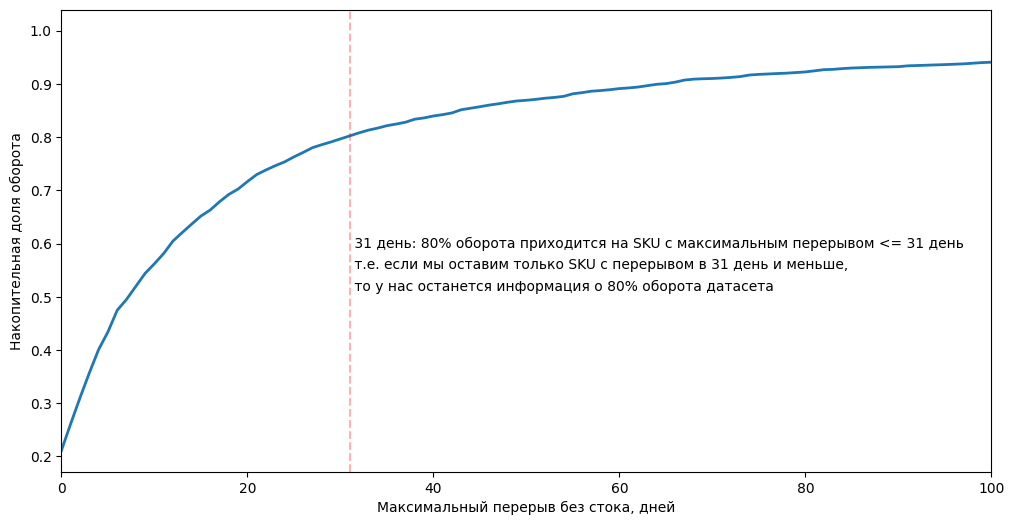

In [12]:
break_viz = max_breaks_df \
    .groupby('max_break', as_index = False) \
    .agg({'SKU_share': 'sum'}) \
    .sort_values('max_break')

break_viz['cumulative_share'] = break_viz['SKU_share'].cumsum()

# Находим значение доли в точке 31 день
# Ищем ближайшее значение max_break к 31
idx = (break_viz['max_break'] - 31).abs().idxmin()
share_at_31 = break_viz.loc[idx, 'cumulative_share']

# Простая визуализация
plt.figure(figsize=(12, 6))
plt.plot(break_viz['max_break'], break_viz['cumulative_share'], linewidth=2)

# Вертикальная линия на 31 день
plt.axvline(x=31, color='red', linestyle='--', alpha=0.3)
plt.text(31, 0.6, f' 31 день: {share_at_31:.0%} оборота приходится на SKU с максимальным перерывом <= 31 день',  verticalalignment='center')
plt.text(31, 0.56, f' т.е. если мы оставим только SKU с перерывом в 31 день и меньше,',  verticalalignment='center')
plt.text(31, 0.52, f' то у нас останется информация о {share_at_31:.0%} оборота датасета',  verticalalignment='center')


plt.xlabel('Максимальный перерыв без стока, дней')
plt.ylabel('Накопительная доля оборота')
plt.xlim(0, 100)
plt.grid(False)
plt.show()

In [13]:
# SKU_id к удалению (эти SKU имеют слишком длинные перерывы в продажах)
sku_to_delete = max_breaks_df.query(" max_break >= 32 ")['SKU_id']

# очищаем полотно от SKU со слишком длинными перерывами в продажах
filtered_df = filtered_df.query("SKU_id not in @sku_to_delete")
filtered_df

,SKU_id,date,stock_qty
0,937821731,2024-01-01,213.0
1,937821731,2024-01-02,211.0
2,937821731,2024-01-03,204.0
3,937821731,2024-01-04,240.0
4,937821731,2024-01-05,234.0
...,...,...,...
14195380,2850435492,2025-09-26,105.0
14195381,2850435492,2025-09-27,96.0
14195382,2850435492,2025-09-28,401.0
14195383,2850435492,2025-09-29,1243.0


### Чистим длинные перерывы без стока

Я использую следующую логику в функции ниже:

- Сортирую датасет по SKU и дате
- Если в датасете товар отсутствует больше 11 дней подряд -> удаляем эти строки
- Иначе - оставляем строки для дальнейшего восстановления спроса

In [14]:
def remove_long_stock_breaks_by_zero_runs(df, max_break_days=32):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    d = d.sort_values(["SKU_id", "date"])
 
    d["is_zero"] = d["stock_qty"].fillna(0).eq(0)
 
    # id блока (меняется, когда is_zero меняется) внутри каждого SKU
    d["run_id"] = (
        d.groupby("SKU_id")["is_zero"]
         .apply(lambda s: s.ne(s.shift()).cumsum())
         .reset_index(level=0, drop=True)
    )
 
    # длина блока
    d["run_len"] = d.groupby(["SKU_id", "run_id"])["is_zero"].transform("size")
 
    # удалить нулевые блоки, которые длиннее порога
    mask_remove = d["is_zero"] & (d["run_len"] > max_break_days)
 
    out = d.loc[~mask_remove].drop(columns=["is_zero", "run_id", "run_len"])
    return out

# Запускаем очистку
filtered_df = remove_long_stock_breaks_by_zero_runs(filtered_df, max_break_days=32)
filtered_df

,SKU_id,date,stock_qty
11249943,140183668,2024-12-14,1.0
11249944,140183668,2024-12-15,6.0
11249945,140183668,2024-12-16,6.0
11249946,140183668,2024-12-17,6.0
11249947,140183668,2024-12-18,5.0
...,...,...,...
14195380,2850435492,2025-09-26,105.0
14195381,2850435492,2025-09-27,96.0
14195382,2850435492,2025-09-28,401.0
14195383,2850435492,2025-09-29,1243.0


### Джойним с продажами, помечаем дни дефицита

In [15]:
data = data.rename(columns = {'Date': 'date'})
data['date'] = pd.to_datetime(data['date'])

cleaned_df = pd.merge(filtered_df,
                      data[['date', 'SKU_id', 'Items_Acc']],
                      on  = ['SKU_id', 'date'],
                      how ='left').fillna(0)

# Итеративный признак дефицита стока.
# Для каждой SKU и каждой даты считаем медиану Items_Acc по предыдущим 7 ДАТАМ, где НЕ было дефицита (т.е. по истории наблюдений, где deficit=0),
# не включая текущую дату. min_periods=3, иначе медиана NaN.
# Если stock_qty на текущую дату < этой медианы -> deficit=1.
# Для первых дат (где < 3 предыдущих не-дефицитных наблюдений) считаем deficit=0.
 
def compute_iterative_deficit(group: pd.DataFrame, window: int = 7, min_periods: int = 3) -> pd.DataFrame:
    group = group.sort_values('date').copy()
 
    items = group['Items_Acc'].to_numpy(dtype=float)
    stock = group['stock_qty'].to_numpy(dtype=float)
 
    n = len(group)
    med_prev = np.full(n, np.nan, dtype=float)
    deficit = np.zeros(n, dtype=int)
 
    non_deficit_history: list[float] = []
 
    for i in range(n):
        if len(non_deficit_history) >= min_periods:
            med_prev[i] = float(np.median(non_deficit_history[-window:]))
 
        if not np.isnan(med_prev[i]) and stock[i] < med_prev[i]:
            deficit[i] = 1
        else:
            deficit[i] = 0
            non_deficit_history.append(items[i])
 
    group['items_acc_median_prev7_nondef'] = med_prev
    group['deficit'] = deficit
    return group
 
cleaned_df = (
    cleaned_df.sort_values(['SKU_id', 'date'])
    .groupby('SKU_id', group_keys=False)
    .apply(compute_iterative_deficit)
)

cleaned_df

/tmp/ipykernel_55/36972141.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_iterative_deficit)


,SKU_id,date,stock_qty,Items_Acc,items_acc_median_prev7_nondef,deficit
0,140183668,2024-12-14,1.0,0.0,NaN,0
1,140183668,2024-12-15,6.0,0.0,NaN,0
2,140183668,2024-12-16,6.0,0.0,NaN,0
3,140183668,2024-12-17,6.0,1.0,0.0,0
4,140183668,2024-12-18,5.0,0.0,0.0,0
...,...,...,...,...,...,...
6109314,2850435492,2025-09-26,105.0,9.0,NaN,0
6109315,2850435492,2025-09-27,96.0,20.0,NaN,0
6109316,2850435492,2025-09-28,401.0,27.0,9.0,0
6109317,2850435492,2025-09-29,1243.0,37.0,14.5,0


In [16]:
cleaned_df.query("SKU_id == 907323049").tail(40)

,SKU_id,date,stock_qty,Items_Acc,items_acc_median_prev7_nondef,deficit
2705696,907323049,2025-08-22,3.0,3.0,70.0,1
2705697,907323049,2025-08-23,2.0,2.0,70.0,1
2705698,907323049,2025-08-24,0.0,5.0,70.0,1
2705699,907323049,2025-08-25,1.0,6.0,70.0,1
2705700,907323049,2025-08-26,1.0,3.0,70.0,1
2705701,907323049,2025-08-27,0.0,1.0,70.0,1
2705702,907323049,2025-08-28,1.0,1.0,70.0,1
2705703,907323049,2025-08-29,1.0,7.0,70.0,1
2705704,907323049,2025-08-30,0.0,1.0,70.0,1
2705705,907323049,2025-08-31,0.0,5.0,70.0,1


### Работа над спросом

In [17]:
def add_lambda_corrected_grouped_median(df, window=30, min_obs=10):
    """
    Robust lambda: rolling median по non-deficit дням + ffill через дефицит.
    Cold-start НЕ заполняем: если non-deficit наблюдений < min_obs -> lambda_corrected = NaN
    Требует: SKU_id, date, Items_Acc, deficit
    """
    def process_group(g):
        g = g.sort_values("date").copy()
 
        # наблюдаемые продажи: дефицит -> NaN (не “0 спрос”)
        y_obs = g["Items_Acc"].where(g["deficit"] == 0)
 
        # если товара “слишком мало” без-дефицитных дней — не оцениваем вообще
        if y_obs.notna().sum() < min_obs:
            g["lambda_estimate"] = np.nan
            g["lambda_corrected"] = np.nan
            return g
 
        # rolling median (робастно к всплескам)
        lam = y_obs.rolling(window=window, min_periods=min_obs).median()
 
        # держим последнюю оценку на дефицитных блоках (не угасает)
        lam = lam.ffill()
 
        g["lambda_estimate"] = lam
 
        # в дефицит -> lambda, иначе -> факт
        g["lambda_corrected"] = np.where(
            g["deficit"] == 1,
            g["lambda_estimate"],
            g["Items_Acc"]
        )
        return g
 
    return df.groupby("SKU_id", group_keys=False).apply(process_group)

# Вызов функции
result_df = add_lambda_corrected_grouped_median(cleaned_df, window=30, min_obs=10)

# Удаляем 211 пропущенных значений lambda_corrected
# Это новые товары, появившиеся только в сентябре, о них нет никакой информации
result_df = result_df[result_df['lambda_corrected'].notna()]

/tmp/ipykernel_55/978806315.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("SKU_id", group_keys=False).apply(process_group)


In [18]:
# ----------------------------------------------------------------------
# ------------------------ СЭМПЛИРОВАНИЕ СПРОСА ------------------------
# ----------------------------------------------------------------------

def restore_demand_grouped(df):
    """Сэмплирование спроса из распределения Пуассона для всех товаров"""
    
    def process_demand_group(group):
        """Обрабатывает одну группу (один товар)"""
        product_data = group.copy()
        
        # Используем lambda_corrected
        lambda_value = product_data["lambda_corrected"].values
        sales_oracle_day = product_data["Items_Acc"].fillna(0).values
        max_sales = product_data["Items_Acc"].max()
        
        # Сэмплирование из Пуассона
        product_data["demand"] = np.fmin(
            np.full(len(lambda_value), max_sales),  # Ограничение сверху
            np.fmax(
                np.random.poisson(lambda_value, size=len(lambda_value)),
                sales_oracle_day  # Ограничение снизу - фактические продажи
            )
        )
        
        return product_data
    
    # Применяем функцию ко всем группам
    result_df = df.groupby('SKU_id').apply(process_demand_group).reset_index(drop=True)
    
    return result_df

# Использование:
result_df = restore_demand_grouped(result_df)

/tmp/ipykernel_55/3077001409.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby('SKU_id').apply(process_demand_group).reset_index(drop=True)


In [19]:
result_df['real_demand'] = np.where(
            result_df['deficit'] == 1,
            result_df['demand'],         # если есть дефицит -> спрос = посчитанный спрос по Пуассону
            result_df['Items_Acc']       # если нет дефицита -> спрос = фактические продажи
        )

result_df

,SKU_id,date,stock_qty,Items_Acc,items_acc_median_prev7_nondef,deficit,lambda_estimate,lambda_corrected,demand,real_demand
0,140183668,2024-12-14,1.0,0.0,NaN,0,NaN,0.0,0.0,0.0
1,140183668,2024-12-15,6.0,0.0,NaN,0,NaN,0.0,0.0,0.0
2,140183668,2024-12-16,6.0,0.0,NaN,0,NaN,0.0,0.0,0.0
3,140183668,2024-12-17,6.0,1.0,0.0,0,NaN,1.0,1.0,1.0
4,140183668,2024-12-18,5.0,0.0,0.0,0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6103131,2839247926,2025-09-26,103.0,16.0,1.0,0,NaN,16.0,16.0,16.0
6103132,2839247926,2025-09-27,92.0,10.0,4.0,0,NaN,10.0,10.0,10.0
6103133,2839247926,2025-09-28,80.0,16.0,10.0,0,7.0,16.0,16.0,16.0
6103134,2839247926,2025-09-29,64.0,32.0,11.0,0,10.0,32.0,32.0,32.0


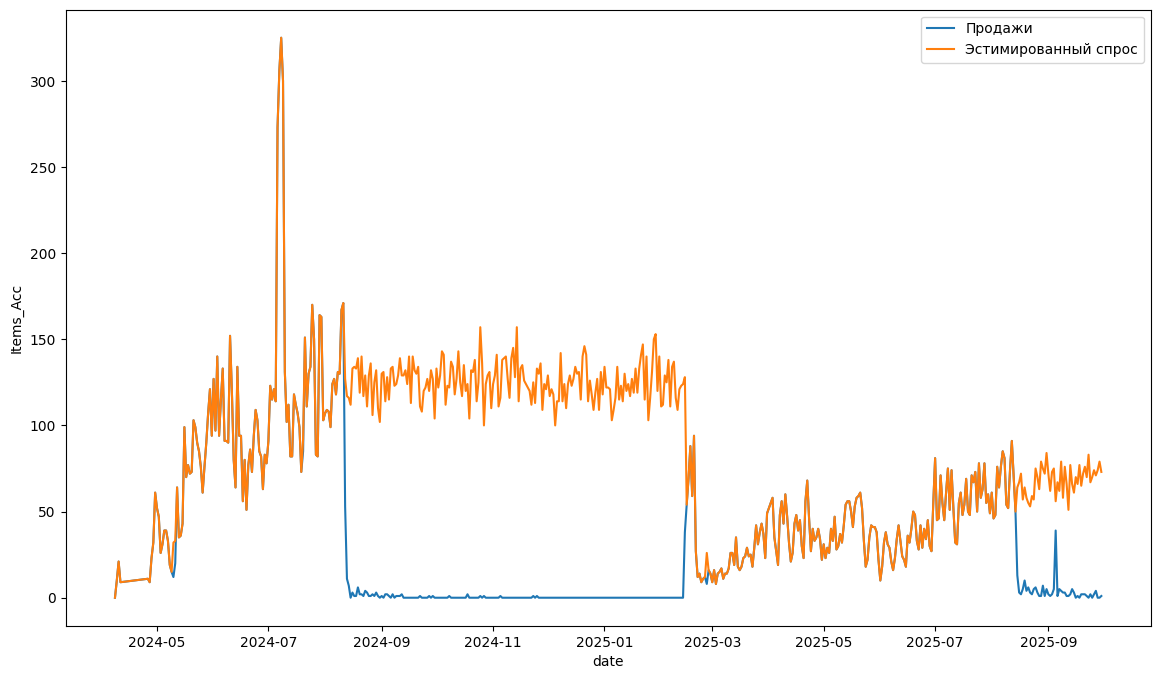

In [20]:
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.lineplot(x = 'date', y = 'Items_Acc', data = result_df.query(" SKU_id == 907323049"), label = 'Продажи')
sns.lineplot(x = 'date', y = 'real_demand', data = result_df.query(" SKU_id == 907323049"), label = 'Эстимированный спрос')
plt.legend()

### Оставшиеся задачи:
- убрать длинные пропуски между датами, кое где остаются косяки
- SKU для проверки алгоритмов:
1. 1329288193, 662100331 - проблема с нулевыми продажами на старте (первые 2 месяца всё по нулям)
2. 177620566, 893929319 - был хаммер, медиана под него подстраивается, и помечает лишние дни как пропуски
3. 907323049 - ульта